In [168]:
# %pip install pandas
# %pip install matplotlib
# %pip install prophet
# %pip install fbprophet
%pip install -U scikit-learn
import pandas as pd
from matplotlib import pyplot
# from prophet import Prophet
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error

     |████████████████████████████████| 26.4 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 67.0 MB/s eta 0:00:01
     |████████████████████████████████| 39.8 MB 27.7 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [80]:
data_base = 'data/daily01/'
url = 'https://github.com/azizamirsaidova/aws_disaster_response_hackathon/blob/main/data/Tornadoes_SPC_1950to2015.csv'
dataset_zip = 'CRND0103-202110250450.zip'
data_file = 'Tornadoes_SPC_1950to2015.csv'

# Download dataset from NOAA website
# if not os.path.isfile(data_base+dataset_zip):
#     !wget --no-check-certificate {url_base}{dataset_zip}
#     !mv {dataset_zip} {data_base}

# # Uncompress the dataset
# if not os.path.isfile(data_base+'HEADERS.txt'):
#     print("Uncompressing the dataset")
#     with zipfile.ZipFile(data_base+dataset_zip, 'r') as zip_ref:
#         zip_ref.extractall(data_base)    
        
        
df = pd.read_csv(data_file)
df

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,fat,loss,closs,slat,slon,elat,elon,len,wid,fc
0,1,1950,1,3,1/3/1950,11:00:00,3,MO,29,1,...,0,6.00,0.0,38.77,-90.22,38.83,-90.03,9.50,150,0
1,2,1950,1,3,1/3/1950,11:55:00,3,IL,17,2,...,0,5.00,0.0,39.10,-89.30,39.12,-89.23,3.60,130,0
2,3,1950,1,3,1/3/1950,16:00:00,3,OH,39,1,...,0,4.00,0.0,40.88,-84.58,0.00,0.00,0.10,10,0
3,4,1950,1,13,1/13/1950,5:25:00,3,AR,5,1,...,1,3.00,0.0,34.40,-94.37,0.00,0.00,0.60,17,0
4,5,1950,1,25,1/25/1950,19:30:00,3,MO,29,2,...,0,5.00,0.0,37.60,-90.68,37.63,-90.65,2.30,300,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60109,607506,2015,12,28,12/28/2015,3:20:00,3,LA,22,0,...,0,0.00,0.0,30.08,-90.54,30.08,-90.53,0.60,150,0
60110,613277,2015,12,28,12/28/2015,4:46:00,3,AR,5,0,...,0,0.05,0.0,34.70,-90.92,34.78,-90.90,5.75,40,0
60111,607307,2015,12,28,12/28/2015,5:43:00,3,MS,28,0,...,0,0.10,0.0,31.54,-89.53,31.61,-89.49,5.59,100,0
60112,612738,2015,12,28,12/28/2015,8:30:00,3,FL,12,0,...,0,0.01,0.0,30.76,-87.24,30.77,-87.23,0.78,75,0


In [114]:
df['timestamp'] = pd.to_datetime(df['date'], format='%Y-%m-%d', infer_datetime_format=True)

In [115]:
df_TX = df[df['st']=='TX']
df_TX

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,loss,closs,slat,slon,elat,elon,len,wid,fc,timestamp
6,7,1950,1,26,1/26/1950,18:00:00,3,TX,48,1,...,0.00,0.0,26.88,-98.12,26.88,-98.05,4.70,133,0,1950-01-26
7,8,1950,2,11,2/11/1950,13:10:00,3,TX,48,2,...,4.00,0.0,29.42,-95.25,29.52,-95.13,9.90,400,0,1950-02-11
8,9,1950,2,11,2/11/1950,13:50:00,3,TX,48,3,...,4.00,0.0,29.67,-95.05,29.83,-95.00,12.00,1000,0,1950-02-11
9,10,1950,2,11,2/11/1950,21:00:00,3,TX,48,4,...,5.00,0.0,32.35,-95.20,32.42,-95.20,4.60,100,0,1950-02-11
10,11,1950,2,11,2/11/1950,23:55:00,3,TX,48,5,...,5.00,0.0,32.98,-94.63,33.00,-94.70,4.50,67,0,1950-02-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60094,606484,2015,12,26,12/26/2015,19:33:00,3,TX,48,0,...,0.60,0.0,33.27,-96.35,33.34,-96.33,5.21,100,0,2015-12-26
60095,606919,2015,12,27,12/27/2015,15:06:00,3,TX,48,0,...,0.01,0.0,33.50,-94.67,33.54,-94.67,2.93,75,0,2015-12-27
60096,606911,2015,12,27,12/27/2015,15:24:00,3,TX,48,0,...,0.04,0.0,32.73,-94.99,32.84,-94.94,7.98,1338,0,2015-12-27
60101,606928,2015,12,27,12/27/2015,16:39:00,3,TX,48,0,...,0.30,0.0,32.62,-94.32,32.73,-94.28,7.78,300,0,2015-12-27


In [232]:
target = 'inj'
timestamp = 'yr'
df_model = df_TX[[timestamp, target]]
df_model.columns = ['ds', 'y']

df_model.head()

,ds,y
6,1950,2
7,1950,0
8,1950,12
9,1950,5
10,1950,6


In [233]:
df_agg0 = df_model.groupby(['ds']).agg({'y':['sum']}).reset_index()
df_agg0

,ds,y
,,sum
0,1950,106
1,1951,118
2,1952,13
3,1953,834
4,1954,131
...,...,...
61,2011,7
62,2012,47
63,2013,67


In [234]:
# df_agg = df_agg['ds']
# df_agg.columns = ['ds','y']
df_agg = pd.DataFrame({'ds':df_agg0['ds'], 'y': df_agg0['y']['sum']})
df_agg

,ds,y
0,1950,106
1,1951,118
2,1952,13
3,1953,834
4,1954,131
...,...,...
61,2011,7
62,2012,47
63,2013,67
64,2014,8


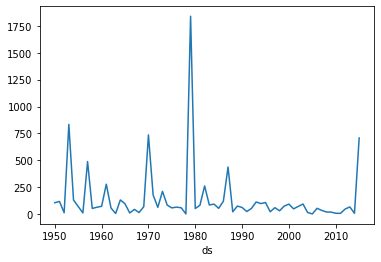

In [235]:
df_plot = df_agg['y']
df_plot.index = df_agg['ds']
df_plot.plot()
pyplot.show()

## Train

In [236]:
train_idx = round(len(df_agg.index)*0.8)
train_set = df_agg[:train_idx]
test_set = df_agg[train_idx:]
test_set

,ds,y
53,2003,94
54,2004,15
55,2005,2
56,2006,54
57,2007,35
58,2008,20
59,2009,19
60,2010,8
61,2011,7
62,2012,47


In [237]:
# define the model
model = Prophet()
# fit the model
model.fit(train_set)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)



Initial log joint probability = -63.5115


Iteration  1. Log joint probability =    58.3382. Improved by 121.85.
Iteration  2. Log joint probability =    62.7614. Improved by 4.42314.
Iteration  3. Log joint probability =    67.4231. Improved by 4.66177.
Iteration  4. Log joint probability =    67.4886. Improved by 0.0654874.
Iteration  5. Log joint probability =    67.5639. Improved by 0.075299.
Iteration  6. Log joint probability =    67.6004. Improved by 0.0364675.
Iteration  7. Log joint probability =    67.6249. Improved by 0.0245196.
Iteration  8. Log joint probability =    67.7435. Improved by 0.118593.
Iteration  9. Log joint probability =    67.7508. Improved by 0.00725511.
Iteration 10. Log joint probability =    67.7595. Improved by 0.00868815.
Iteration 11. Log joint probability =    67.7843. Improved by 0.0248304.
Iteration 12. Log joint probability =    67.8186. Improved by 0.0343424.
Iteration 13. Log joint probability =     67.884. Improved by 0.065377.
Iteration 14. Log joint probability =    68.0498. Improved 

## Test

In [238]:
future = pd.DataFrame(test_set.loc[:,'ds'])
future

,ds
53,2003
54,2004
55,2005
56,2006
57,2007
58,2008
59,2009
60,2010
61,2011
62,2012


In [239]:
# use the model to make a forecast
forecast = model.predict(future)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


          ds        yhat  yhat_lower  yhat_upper
0 2003-01-01   89.692252 -279.774788  440.228638
1 2004-01-01   47.589296 -294.476391  421.868671
2 2005-01-01  135.392223 -202.310898  472.557772
3 2006-01-01  113.796337 -244.749159  457.311087
4 2007-01-01   81.929995 -265.890480  438.552080


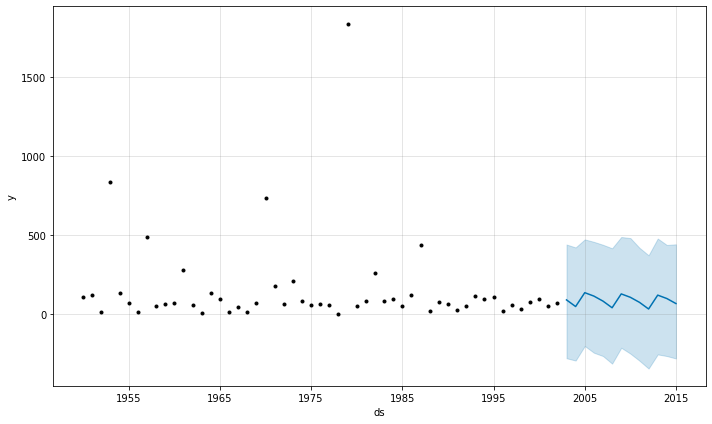

In [240]:
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()

MAE: 105.411


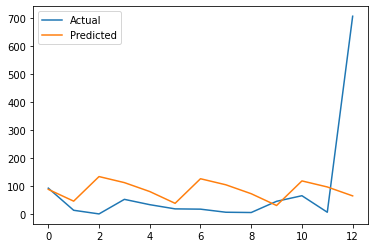

In [241]:
# calculate MAE between expected and predicted values for december
y_true = test_set['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

## Predict next year

In [249]:
next_ds = pd.DataFrame({'ds':[202322]})

,ds
0,2023


In [250]:
next_yr = model.predict(next_ds)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [253]:
next_yr['yhat'].values

array([50.88096752])